# Footstep Planning via Graph of Convex Sets

In [1]:
# python libraries
import numpy as np
from IPython.display import IFrame, display
from matplotlib import pyplot as plt
from matplotlib import rcParams
from pydrake.all import (
    GraphOfConvexSets,
    GraphOfConvexSetsOptions,
    HPolyhedron,
    Point,
)
from pydrake.solvers import SnoptSolver
from underactuated.exercises.grader import Grader
from underactuated.exercises.humanoids.footstep_planning_gcs_utils import (
    animate_footstep_plan,
    plot_rectangle,
)
from underactuated.exercises.humanoids.test_footstep_planning_gcs import (
    TestFootstepPlanning,
)
rcParams["figure.figsize"] = (10, 5)

from testing_footstep_helpers import SteppingStone, Terrain, footstep2position

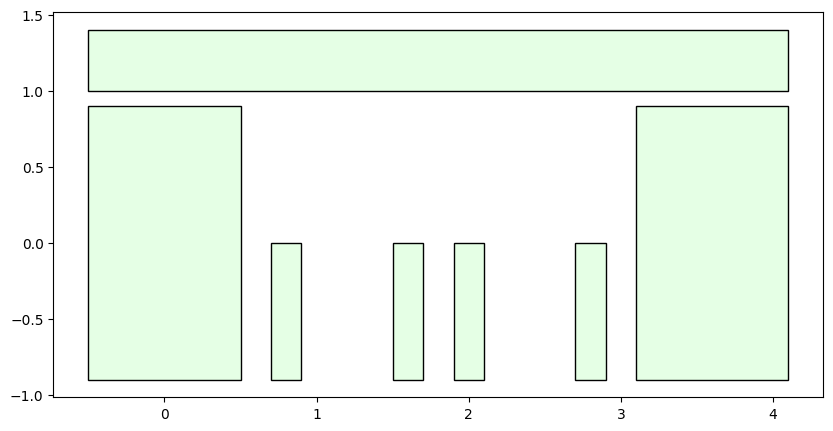

In [19]:
Terrain([1, 0, 1, 1, 0, 1]).plot()

In [20]:
def add_vertex_and_edges_for_set_copies(G, T, step_span):
    start_position = tuple(T.get_stone_by_name("initial").center)
    end_position = tuple(T.get_stone_by_name("goal").center)

    V = []  # vertices
    E_list = (
        []
    )  # list of pair of vertices that can construct an edge e.g. E_list[i] = [u_i, v_i] where u_i -> v_i is a valid edge

    V.append(G.AddVertex(Point(start_position), "source"))
    V.append(G.AddVertex(Point(end_position), "target"))

    # compute number of copies needed for each vertex
    num_copy_lateral = int(
        np.floor(T.get_stone_by_name("lateral").width / step_span) + 2
    )
    num_copy_s_t = int(
        np.floor(T.get_stone_by_name("initial").width / step_span) + 2
    )
    num_copy_bridge = int(
        np.floor(T.get_stone_by_name("bridge_0").width / step_span) + 2
    )

    for i, stone in enumerate(T.stepping_stones):
        H_i = HPolyhedron(stone.A, stone.b)
        if stone.name == "lateral":
            for ii in range(num_copy_lateral):
                V.append(G.AddVertex(H_i, f"l{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])
        elif stone.name == "start":
            for ii in range(num_copy_s_t):
                V.append(G.AddVertex(H_i, f"s{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])
        elif stone.name == "final":
            for ii in range(num_copy_s_t):
                V.append(G.AddVertex(H_i, f"f{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])
        else:
            for ii in range(num_copy_bridge):
                V.append(G.AddVertex(H_i, f"b{i}_{ii}"))
                if ii > 0:
                    # add edge from parent to copy
                    E_list.append([V[-2], V[-1]])

    return G, V, E_list

In [21]:
def add_edges_towards_parent_vertices(G, V, E_list):
    for u in V:
        if u.name() == "target":
            continue
        for v in V:
            if u.name() == v.name():
                continue
            if v.name() == "source":
                continue
            # Don't connect between copies of the same stone (the only edges are added above)
            # if u.name().split("_")[0] == v.name().split("_")[0] and int(u.name().split("_")[1]) != int(v.name().split("_")[1])-1:
            if u.name().split("_")[0] == v.name().split("_")[0]:
                continue
            # Only connect *to* the first copy.
            if (
                len(v.name().split("_")) == 2
                and v.name().split("_")[-1] != "0"
            ):
                continue
            E_list.append([u, v])

    return G, E_list

In [22]:
def add_edge_constraints_costs(G, E_list, step_span):
    E = []

    for u, v in E_list:
        e = G.AddEdge(u, v)
        # Add kinematic constraints to the edges
        e.AddConstraint(e.xu()[0] - e.xv()[0] <= step_span / 2)
        e.AddConstraint(e.xv()[0] - e.xu()[0] <= step_span / 2)

        e.AddConstraint(e.xu()[1] - e.xv()[1] <= step_span / 2)
        e.AddConstraint(e.xv()[1] - e.xu()[1] <= step_span / 2)

        # Add Euclidean distance squared as edge cost
        # e.AddCost((e.xu() - e.xv()).dot(e.xu() - e.xv()))
        e.AddCost(1)
        
        # Add edge object to the graph
        E.append(e)

    return G, E

In [23]:
def GCS_footstep_planner(T, step_span, convex_relaxation, solver):
    # Initial GCS problem
    G = GraphOfConvexSets()

    # Add vertices and edges
    G, V, E_list = add_vertex_and_edges_for_set_copies(G, T, step_span)
    G, E_list = add_edges_towards_parent_vertices(G, V, E_list)

    # Add edge constraints and costs
    G, E = add_edge_constraints_costs(G, E_list, step_span)

    # solve the shortest path problem on GCS
    options = GraphOfConvexSetsOptions()
    options.preprocessing = True
    options.max_rounded_paths = 10
    options.convex_relaxation = convex_relaxation
    options.solver = solver
    result = G.SolveShortestPath(V[0], V[1], options)

    assert result.is_success()

    edges = G.GetSolutionPath(V[0], V[1], result)
    vertex_path = [edge.u() for edge in edges] + [edges[-1].v()]
    path = [v.name() for v in vertex_path]
    path_position = np.array([result.GetSolution(v.x()) for v in vertex_path])

    
    # minimum number of steps cost
    path_cost = len(path) - 1
    # Convert path_position to left and right foot position
    position_left, position_right = footstep2position(path_position)


    return position_left, position_right, path_cost

In [24]:
def generate_and_animate_footstep_plan(
    terrain, step_span, convex_relaxation, solver, title=None
):
    # run footstep planner
    position_left, position_right, path_cost = GCS_footstep_planner(
        terrain, step_span, convex_relaxation, solver
    )

    # print(step_span, position_left, position_right)

    # animate result
    animate_footstep_plan(
        terrain, step_span, position_left, position_right, title
    )

    return position_left, position_right, path_cost

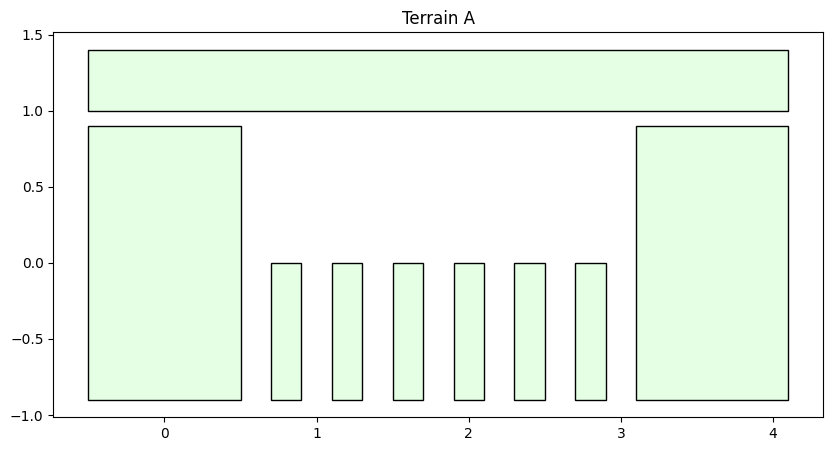

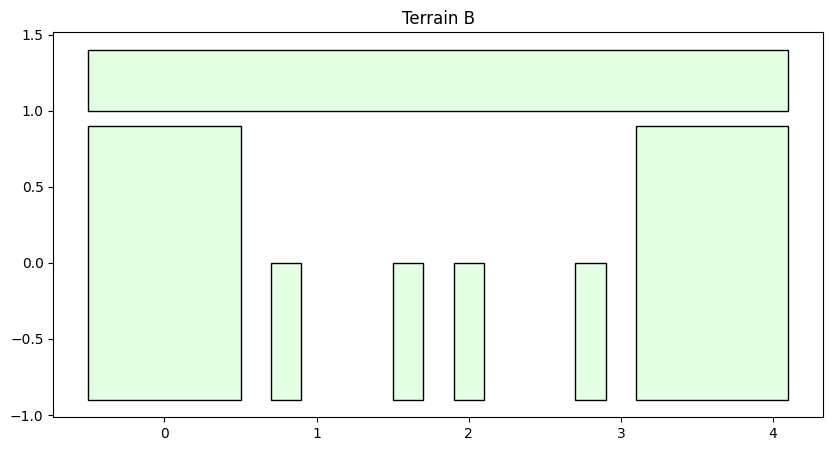

In [25]:
# complete bridge
terrain_A = Terrain([1, 1, 1, 1, 1, 1])
terrain_A.plot("Terrain A")
plt.show()

# # one stepping stone missing in the bridge
terrain_B = Terrain([1, 0, 1, 1, 0, 1])
terrain_B.plot("Terrain B")
plt.show()

In [26]:
step_span = 0.8
convex_relaxation = False

from pydrake.all import MosekSolver
solver = MosekSolver()

position_left_A, position_right_A, cost_A = generate_and_animate_footstep_plan(
    terrain_A, step_span, convex_relaxation, solver
)
print(cost_A)
position_left_B, position_right_B, cost_B = generate_and_animate_footstep_plan(
    terrain_B, step_span, convex_relaxation, solver
)
print(cost_B)

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=false and preprocessing=true and no rounding.


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=false and preprocessing=true and no rounding.


9


11
